In [1]:
import io
import pickle
import numpy as np 
import pandas as pd 
import librosa 
import os 
import soundfile as sf
import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM 
from keras import regularizers
from keras import optimizers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nReached 92% accuracy so cancelling training!")
      self.model.stop_training = True    

In [3]:
def initialise_training_set():
    x_train = pd.read_csv('/kaggle/input/gender/Processed (.csv)/x_train.csv')
    x_test = pd.read_csv('/kaggle/input/gender/Processed (.csv)/x_test.csv')
    y_train = pd.read_csv('/kaggle/input/gender/Processed (.csv)/y_train.csv')
    y_test = pd.read_csv('/kaggle/input/gender/Processed (.csv)/y_test.csv')
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    x_train = x_train.to_numpy()
    print("Loading done")
    return x_train, y_train, x_test, y_test

In [4]:
def initialise_test_set():
    m=[]
    f=[]
    path_female = '/kaggle/input/gender-test/Recorded Samples/Female'
    path_male = '/kaggle/input/gender-test/Recorded Samples/Male'
    for audiofile in os.listdir(path_male):
        try:
            y, sr = sf.read(os.path.join(path_male,audiofile))
            y = librosa.resample(y, sr, 8000)
            y = y[:40000]
            y = np.concatenate((y, [0]* (40000 - y.shape[0])), axis=0)
            m.append(y)
        except RuntimeError:
            print(".DS_Store file detected and dismissed")
            pass
    for audiofile in os.listdir(path_female):     
        try:
            y, sr = sf.read(os.path.join(path_female,audiofile))
            y = librosa.resample(y, sr, 8000)
            y = y[:40000]
            y = np.concatenate((y, [0]* (40000 - y.shape[0])), axis=0)
            f.append(y)
        except RuntimeError:
            print(".DS_Store file detected and dismissed")   
            pass
    labels_m = [1] * 14
    labels_f = [0] * 10
    set_m = list(zip(m,labels_m))
    set_f = list(zip(f,labels_f))
    data = set_m + set_f 
    df = pd.DataFrame(data, columns = ['Audio Data', 'Label'])
    return df


def shuffle_test_set(test):
    test = test.reindex(np.random.permutation(test.index))
    return test

def from_dataframe_to_array(test_shuff):
    test = test_shuff.values 
    x_test = np.zeros(shape=(test.shape[0],40000))
    for i in range(0,test.shape[0]):
        for j in range(0,40000):
            x_test[i][j] = test[i][0][j]        
    y_test = test_shuff["Label"][:]
    return x_test, y_test 

In [5]:
def model(x_train,x_test,y_train,y_test):
   
    model = Sequential() 
    model.add(CuDNNLSTM(64, input_shape=(x_train.shape[1:]), kernel_initializer= 'glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(32, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    print(x_train.shape)
    print(y_train.shape)
    callbacks = myCallback()
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=512, batch_size=32, callbacks=[callbacks], verbose=2)
    #model.save('/Users/bhargavdesai/Desktop/Gender/Gender Classification /Models/gc11_(128-125)_trained-on-mac.h5')
    print("Saved model to disk")    
    score = model.evaluate(x_test, y_test, batch_size=32)
    del model
    return history, score

In [6]:
def main():
    accuracies = []
    losses = []
    val_losses = []
    val_accuracies = []
    scores=[]
    x_train, y_train, x_test, y_test = initialise_training_set()
    test = initialise_test_set()
    test_shuff = shuffle_test_set(test)
    x_test, y_test = from_dataframe_to_array(test_shuff)
    print('Starting training for the models...')
    shapes = [(800, 50), (400, 100)]
    #colours = ['b','g','r','c']
    labels_for_plot = ['50 features per timestep', '100 features per time step']
    for i in range(len(shapes)):
        shape = np.array(shapes[i])
        print('Training and Plotting for shape:   ', shape)
        x_train = x_train.reshape(x_train.shape[0], shape[0], shape[1])
        x_test = x_test.reshape(x_test.shape[0], shape[0], shape[1])
        print(x_test.shape)
        print(y_test.shape)
        history, score = model(x_train,x_test,y_train,y_test)
        print(score)
        scores.append(score)
        # list all data in history
        print(history.history.keys())
        # summarize and save history for accuracy, loss and validation loss and validation accuracy
        accuracy = history.history['accuracy']
        accuracies.append(accuracy)
        loss = history.history['loss']
        losses.append(loss)
        val_loss = history.history['val_loss']
        val_losses.append(val_loss)
        val_acc = history.history['val_accuracy']
        val_accuracies.append(val_acc)
        plt.plot(history.history['accuracy'], label=labels_for_plot[i])
        #plt.plot(history.history['val_accuracy'])
        
    # accuracies    
    
    plt.title('Model accuracy with different number of features per timestep')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=0.3)    
    plt.savefig('/kaggle/working/table3_50f_and_100f_acc.png', bbox_inches='tight', dpi=100)
    plt.show()
    
    
    return accuracies, losses, val_losses, val_accuracies, scores

Loading done
Starting training for the models...
Training and Plotting for shape:    [800  50]
(24, 800, 50)
(24,)
(7715, 800, 50)
(7715, 1)
Train on 7715 samples, validate on 24 samples
Epoch 1/512
7715/7715 - 21s - loss: 0.6877 - accuracy: 0.5019 - val_loss: 0.6972 - val_accuracy: 0.4167
Epoch 2/512
7715/7715 - 8s - loss: 0.6857 - accuracy: 0.5200 - val_loss: 0.7012 - val_accuracy: 0.1250
Epoch 3/512
7715/7715 - 8s - loss: 0.6857 - accuracy: 0.5207 - val_loss: 0.6955 - val_accuracy: 0.4167
Epoch 4/512
7715/7715 - 8s - loss: 0.6853 - accuracy: 0.5237 - val_loss: 0.6962 - val_accuracy: 0.4167
Epoch 5/512
7715/7715 - 8s - loss: 0.6853 - accuracy: 0.5233 - val_loss: 0.6965 - val_accuracy: 0.4167
Epoch 6/512
7715/7715 - 8s - loss: 0.6845 - accuracy: 0.5250 - val_loss: 0.6966 - val_accuracy: 0.4167
Epoch 7/512
7715/7715 - 8s - loss: 0.6837 - accuracy: 0.5264 - val_loss: 0.6954 - val_accuracy: 0.4167
Epoch 8/512
7715/7715 - 8s - loss: 0.6844 - accuracy: 0.5275 - val_loss: 0.6666 - val_accur

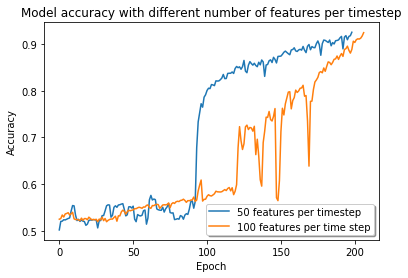

Saving the objects now
Saved as pickle


In [7]:
accuracies, losses, val_losses, val_accuracies, scores = main()

print('Saving the objects now')

# Saving the objects:
with open('/kaggle/working/objs_for_50f_and_100f.pkl', 'wb') as f:  
    pickle.dump([accuracies, losses, val_losses, val_accuracies, scores], f)
    
print('Saved as pickle')    
